In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [2]:
dataset_path = "data/archive/Data/genres_original"
json_path = "data/gtzan_mfcc_json.json"


## 1. Neural Network

In [3]:
with open(json_path, "r") as fp:
        data = json.load(fp)
        
# convert lists to numpy arrays
X = np.array(data["mfcc"])
y = np.array(data["labels"])

print(X.shape)
print(y.shape)

(9986, 130, 13)
(9986,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
print("Training set: ")
print(X_train.shape)
print(y_train.shape)

print("Testing set: ")
print(X_test.shape)
print(y_test.shape)

Training set: 
(6990, 130, 13)
(6990,)
Testing set: 
(2996, 130, 13)
(2996,)


### 1.1 Model Trainer Function

We create a function which takes in model and it's short name as
parameters (and an option learning rate).
The function compiles, trains and then plots the model,
saving the training history in JSON file (for later use) and the plots.

In [6]:
def compile_train_plot(model, name, lr=0.0001):
    optimiser = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    # Train the model
    print("Training in progress...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50, verbose=0)
    print("Training finished")
    fig, axs = plt.subplots(2)
    
    # Save training history in JSON file
    with open("img/train_test_plot_"+name+".json", 'w') as file:
        json.dump(history.history, file)

    # Accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.tight_layout()
    plt.savefig("img/train_test_plot_"+name+".png", format="png", dpi=200)
    plt.show()

### 1.2 Basic Model

Model with 2 hidden layer without any dropout/regualarisation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 1,133,578
Trainable params: 1,133,578
Non-trainable params: 0
_________________________________________________________________
Training in progress...
Training finished


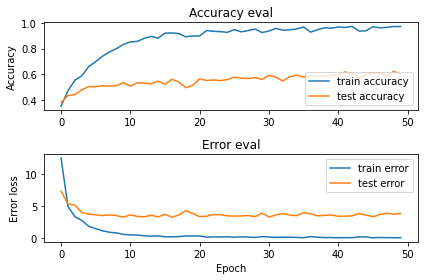

In [7]:
model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

compile_train_plot(model, "basic")

Some remarks:

* The testing accuracy as well as error both improved in their own respective
ways, but there is a huge difference between the training and testing curves.

* The test error did decrease, and then actually began to increase.

The above points indicate that the current model is severely overfitting,
and hence we need to change some parameters of the model, or use a completely
different model. 

## 2. Improved Neural Network
Now incorporating dropouts and regularization

### 2.1 Dropout

Model with 2 hidden layers with 10% droput rate

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 1,133,578
Trainable params: 1,133,578
Non-trainable params: 0
____________________________________________

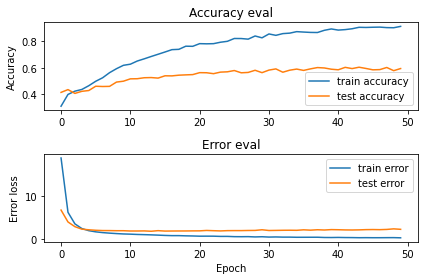

In [8]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(10, activation='softmax'))

compile_train_plot(model, name="drop")

### 2.2 Dropout + Regularization

Model with 2 hidden layers with 10% dropout rate and L2 regularization
in each of the hidden layers.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 1,133,578
Trainable params: 1,133,578
Non-trainable params: 0
____________________________________________

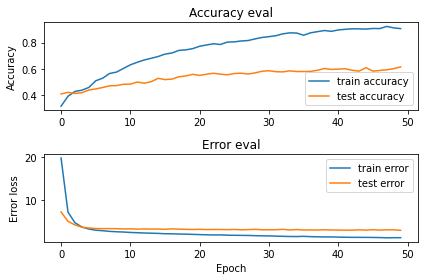

In [9]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.001)))

compile_train_plot(model, name="drop_regu")


### 2.3 Dropout + Regulrization + More layers

More hidden layers added

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

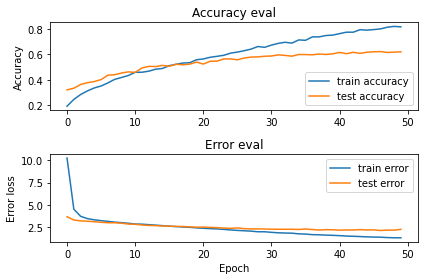

In [10]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))

model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.001)))

compile_train_plot(model, name="drop_regu_3layers")